# Setup

In [2]:
# Standard imports
from g4beam import *
from scan import *

import math
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from tqdm import *
import pickle
import itertools

# Get example data

Data can be imported here or generated with **First wedge single case**

In [41]:
# Import some data from our previous experiments
post_wedge = read_trackfile("results/distributions/110_After.txt")

In [42]:
print_all_params(post_wedge)

-----------------------------
Twiss parameters for X
emit  = 0.03623610136303908 mm
beta  = 0.03764375907893395 m
gamma = 218.68291027746653 1/m
alpha = -2.689246509557106
D     = 0.017683021068306173 m
D'    = 0.05061059174336235

Twiss parameters for Y
emit  = 0.11774053414952483 mm
beta  = 0.026090707971794323 m
gamma = 65.87886637641928 1/m
alpha = -0.8478362248335556
D     = 3.794587717305216e-05 m
D'    = -0.015461136897480113

Z-emittance:  6.46989261517675 mm
Z std: 143.2468714595459 mm
pZ std: 7.472330766903874 MeV/c
Mean momentum: 87.9372217392352 MeV/c
-----------------------------


# Dispersion correction and separate transverse

In [10]:
# Calculate dispersion correction
post_correct = remove_dispersion(post_wedge)

# Ignore transverse momentums
no_transverse = remove_transverse(post_correct)

# Reverse transverse momentums in saved copy
reverse_transverse = post_correct.copy(deep=True)
reverse_transverse["Px"] *= -1
reverse_transverse["Py"] *= -1

# Individual run

In [47]:
optim_result.x

array([1.42071681e+02, 5.63445391e+03, 5.39288950e+00])

In [26]:
rf_length = 5795.221799131141
drift_length = 16000
rf_freq = 0.025
rf_grad = 5.642453288171298
rf_phase = 128.8869837730719

drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
post_cavity = recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))
beep()

Text(0.5, 0.98, 'Drift length 16.0 m, RF length 5.8 m, RF frequency 25.00 MHz, RF gradient 5.6 MV/m, RF phase 129 deg\nCut loss: 15.0%')

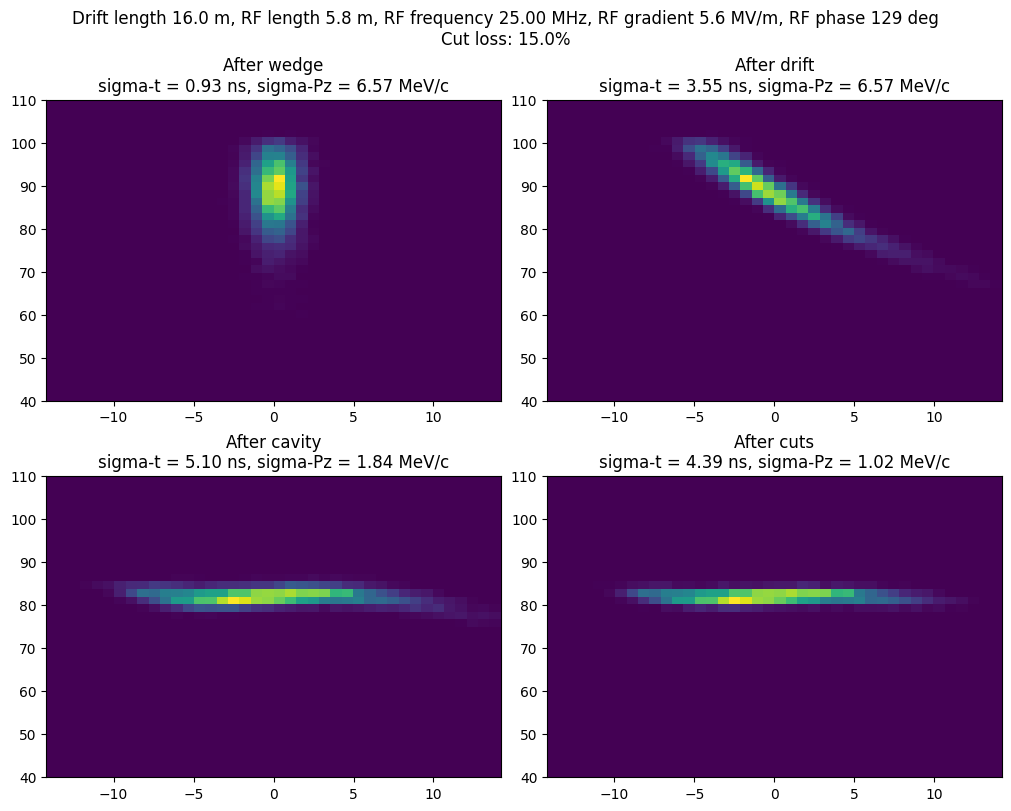

In [27]:
# post_cut = post_cavity[(post_cavity["Pz"] > 82) & (post_cavity["Pz"] < 92)]
post_cut = cut_pz(post_cavity)
cut_loss = 1 - len(post_cut)/len(post_cavity)

PLOT_TARGETS = [post_correct, post_drift, post_cavity, post_cut]
PLOT_TITLES = ["After wedge", "After drift", "After cavity", "After cuts"]
T_RADIUS = 4*np.std(post_drift["t"])
P_RANGE = [40, 110]

fig, axs = plt.subplots(nrows=2, ncols=2, layout="constrained")
fig.set_size_inches(10, 8)
axs = axs.flatten()
for df, title, ax in zip(PLOT_TARGETS, PLOT_TITLES, axs):
    std_t = np.std(df["t"])
    std_Pz = np.std(df["Pz"])
    ax.hist2d(df["t"], df["Pz"], bins=40, range=[[-T_RADIUS, +T_RADIUS], P_RANGE])
    ax.set_title(title + f"\nsigma-t = {std_t:.2f} ns, sigma-Pz = {std_Pz:.2f} MeV/c")
fig.suptitle(f"Drift length {drift_length/1000:.1f} m, RF length {rf_length/1000:.1f} m, RF frequency {rf_freq*1000:.2f} MHz, RF gradient {rf_grad:.1f} MV/m, RF phase {rf_phase:.0f} deg\nCut loss: {cut_loss:.1%}")

In [28]:
print_all_params(post_cut)

-----------------------------
Twiss parameters for X
emit  = 4.74806025705209e-06 mm
beta  = 232.72427944274472 m
gamma = 0.029648041576610076 1/m
alpha = 2.4289543249730157
D     = 0.0016763162314591888 m
D'    = 1.2739194706294064e-05

Twiss parameters for Y
emit  = 1.2622617240811252e-05 mm
beta  = 227.4934144428024 m
gamma = 0.02847363686403111 1/m
alpha = 2.340419806744697
D     = 0.0005414481141860489 m
D'    = 4.93588437442956e-07

Z-emittance:  4.782799887049952 mm
Z std: 806.6111294864198 mm
pZ std: 1.0222010380203392 MeV/c
Mean momentum: 82.00138838728176 MeV/c
-----------------------------


# Various tests (old)
This was before I fixed the drift/phase issue, so most of these are irrelevant

In [20]:
rf_lengths = list(range(1500, 2501, 50))
post_cavity_results = list()
for l in tqdm(rf_lengths):
    post_cavity_results.append((l, run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=l)))
with open("results/angle_scan_temit.pkl", "wb+") as file:
    pickle.dump(results, file)
beep()

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [03:25<00:00,  9.80s/it]


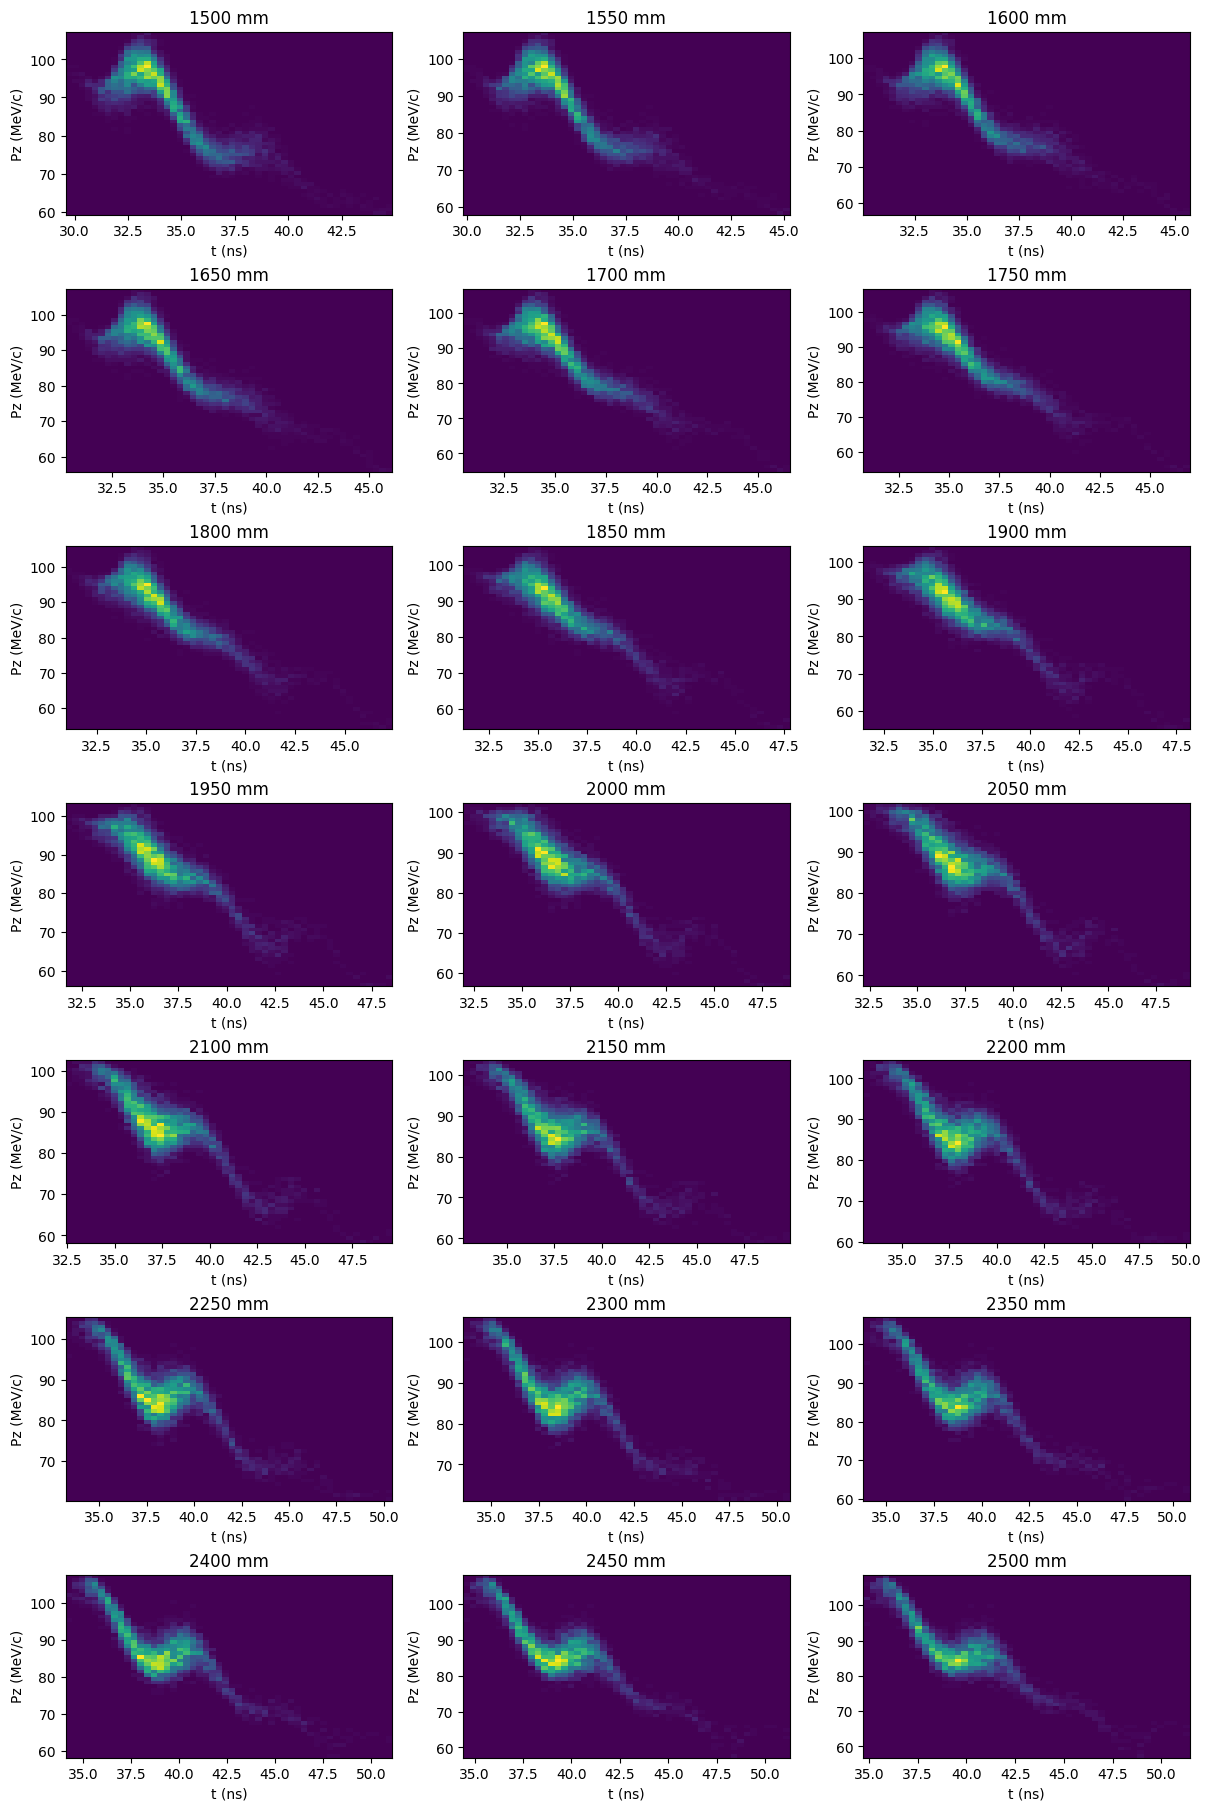

In [26]:
fig, axs = plt.subplots(nrows=7, ncols=3, layout="constrained")
fig.set_size_inches(12, 18)
axs = axs.flatten()
for ax, (l, post_cavity) in zip(axs, post_cavity_results):
    ax.hist2d(post_cavity["t"], post_cavity["Pz"], bins=50)
    ax.set_xlabel("t (ns)")
    ax.set_ylabel("Pz (MeV/c)")
    ax.set_title(f"{l} mm")

In [83]:
drift_lengths = np.linspace(3500, 6500, 16)
def fun(l):
    post_drift = z_prop(post_correct, l)
    return(run_g4beam(post_drift, "G4_RFCavity.g4bl"))
run_scan(fun, (drift_lengths,), "results/scan_drift_length.pkl")

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:38<00:00,  9.90s/it]


[(3500.0,
               x         y     z        Px        Py       Pz        t  PDGid  \
  0    -105.4810 -150.3540  2550 -3.378520 -4.656560  89.3079  29.3252     13   
  1     -50.1327  -62.2608  2550 -1.609630 -2.001380  90.3706  29.2424     13   
  2     -28.6783 -140.7440  2550 -0.952062 -4.741280  99.1281  29.8548     13   
  3     262.6120   68.1909  2550  9.609980  2.444700  91.3087  31.3781     13   
  4     183.4140   92.3409  2550  7.536960  3.727480  92.8034  32.4451     13   
  ...        ...       ...   ...       ...       ...      ...      ...    ...   
  5887 -107.0030   18.7249  2550 -4.064250  0.630696  94.4171  31.3976     13   
  5888  -23.9201 -178.8010  2550 -0.919255 -7.045540  87.3902  32.4297     13   
  5889  -17.9807 -195.3550  2550 -0.610934 -6.567560  95.5578  30.4291     13   
  5890 -197.6620   54.7505  2550 -7.357170  2.022760  84.2289  32.8708     13   
  5891  224.3880 -158.8980  2550  6.804220 -4.847830  88.0329  29.9062     13   
  
        EventID

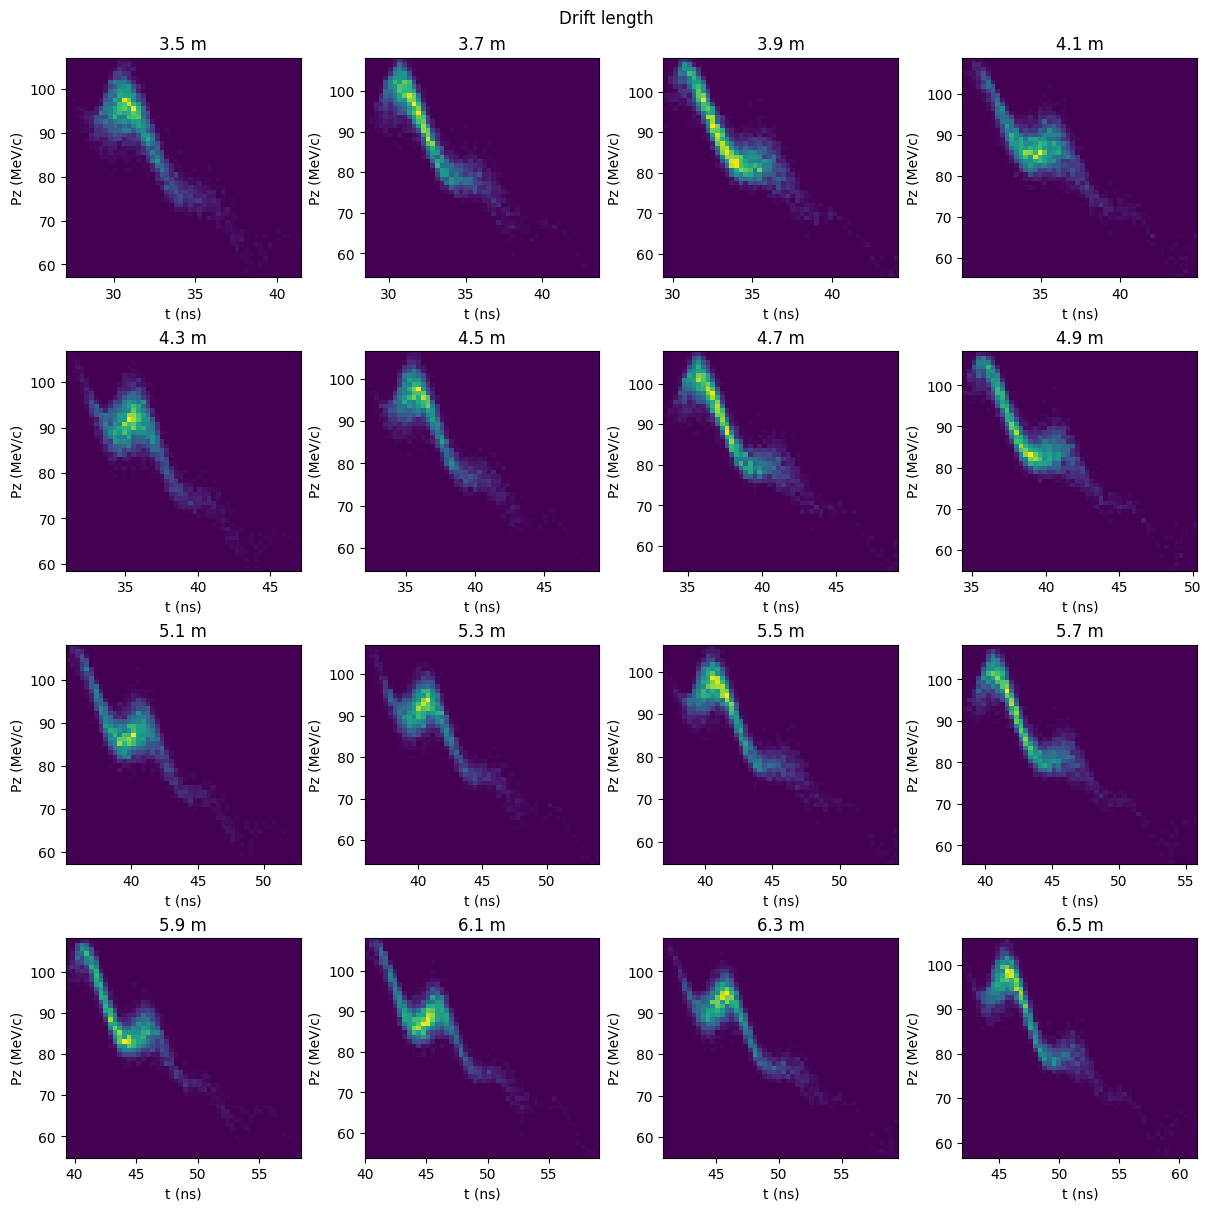

In [86]:
with open("results/scan_drift_length.pkl", "rb") as file:
    results = pickle.load(file)

fig, axs = plt.subplots(nrows=4, ncols=4, layout="constrained")
fig.set_size_inches(12, 12)
fig.suptitle("Drift length")
axs = axs.flatten()
for ax, (l, r) in zip(axs, results):
    ax.hist2d(r["t"], r["Pz"], bins=50)
    ax.set_xlabel("t (ns)")
    ax.set_ylabel("Pz (MeV/c)")
    ax.set_title(f"{l/1000:.1f} m")

In [33]:
freqs = np.linspace(0.1, 0.20125, 16)
results = list()
post_drift = z_prop(post_correct, 5000)
for f in tqdm(freqs):
    post_cavity = run_g4beam(post_drift, "G4_RFCavity.g4bl", frfcool=f)
    results.append((f, post_cavity))

with open("results/scan_rf_freq.pkl", "wb+") as file:
    pickle.dump(results, file)
beep()

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:39<00:00,  9.96s/it]


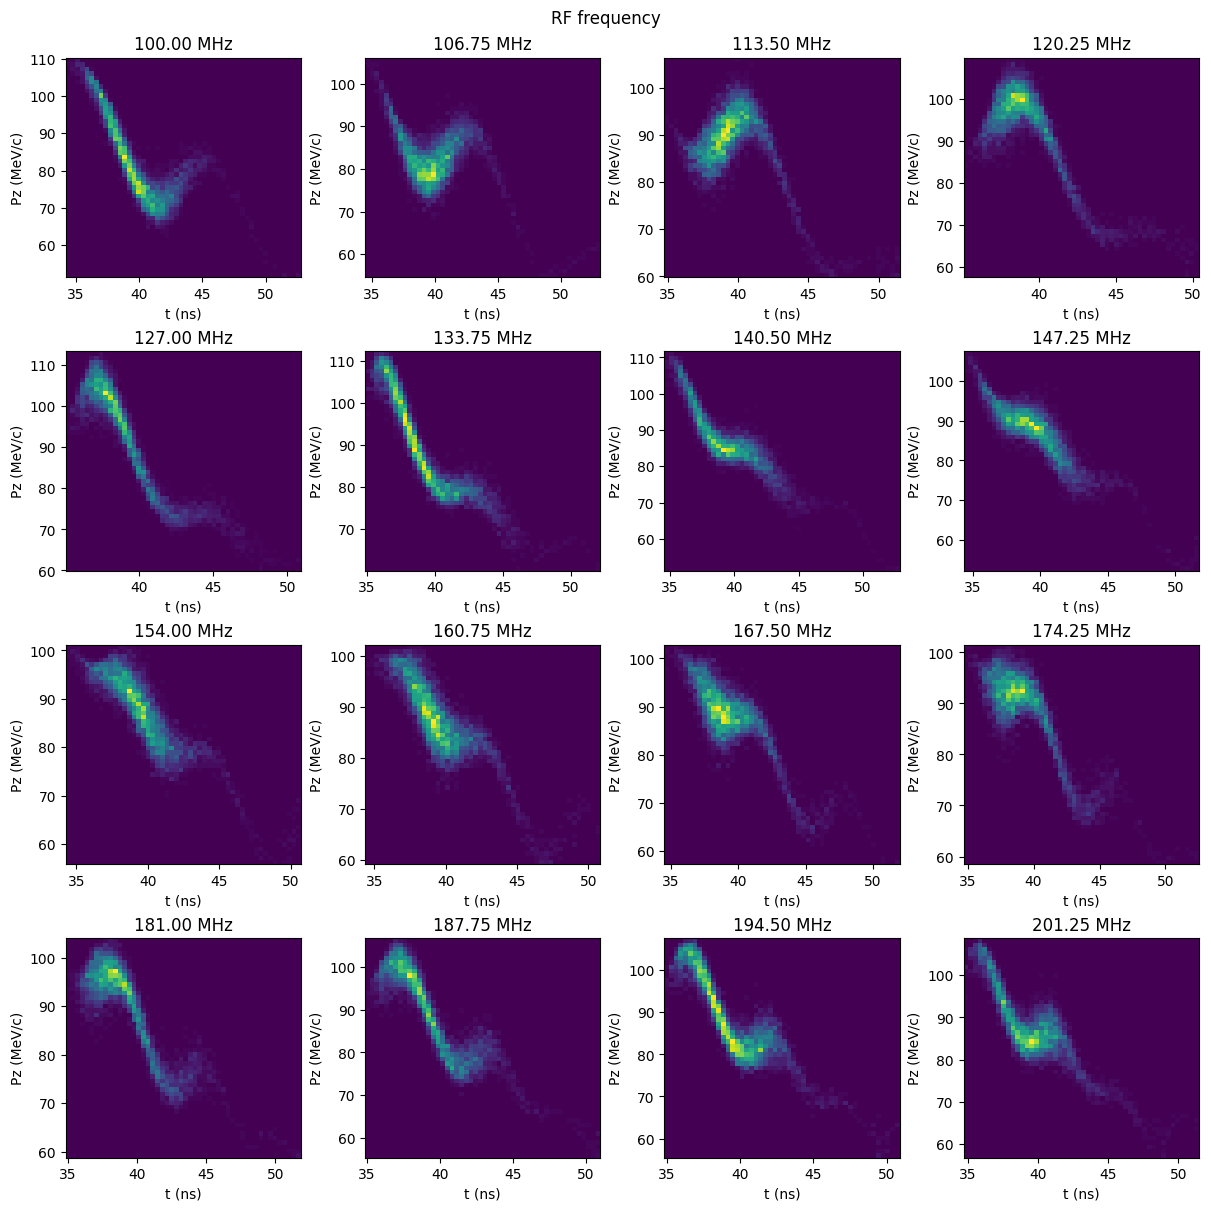

In [78]:
with open("results/scan_rf_freq.pkl", "rb") as file:
    results = pickle.load(file)

fig, axs = plt.subplots(nrows=4, ncols=4, layout="constrained")
fig.suptitle("RF frequency")
fig.set_size_inches(12, 12)
axs = axs.flatten()
for ax, (f, r) in zip(axs, results):
    ax.hist2d(r["t"], r["Pz"], bins=50)
    ax.set_xlabel("t (ns)")
    ax.set_ylabel("Pz (MeV/c)")
    ax.set_title(f"{f*1000:.2f} MHz")

Text(0.5, 0, 'RF frequency (GHz)')

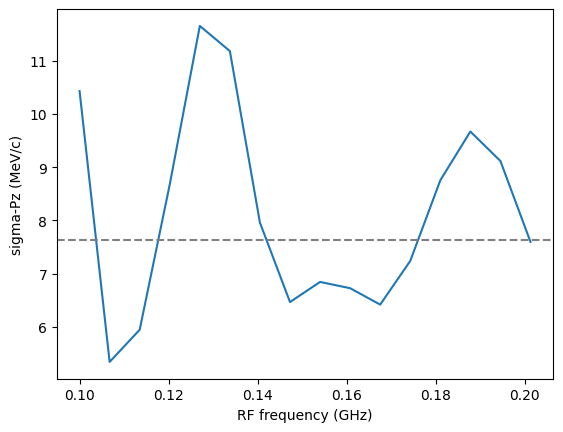

In [11]:
with open("results/scan_rf_freq.pkl", "rb") as file:
    results = pickle.load(file)

fig, ax = plt.subplots()
xlist, ylist = list(), list()
for x, res in results:
    xlist.append(x)
    ylist.append(np.std(res["Pz"]))
ax.plot(xlist, ylist)
ax.axhline(np.std(post_correct["Pz"]), linestyle="--", color="gray")
ax.set_ylabel("sigma-Pz (MeV/c)")
ax.set_xlabel("RF frequency (GHz)")

In [89]:
gradients = np.linspace(8, 32, 16)
post_drift = z_prop(post_correct, 5000)
def fun(gradient):
    return run_g4beam(post_drift, "G4_RFCavity.g4bl", Vrfcool=gradient)
run_scan(fun, (gradients,), "results/scan_rf_grad.pkl")
pass

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:37<00:00,  9.86s/it]


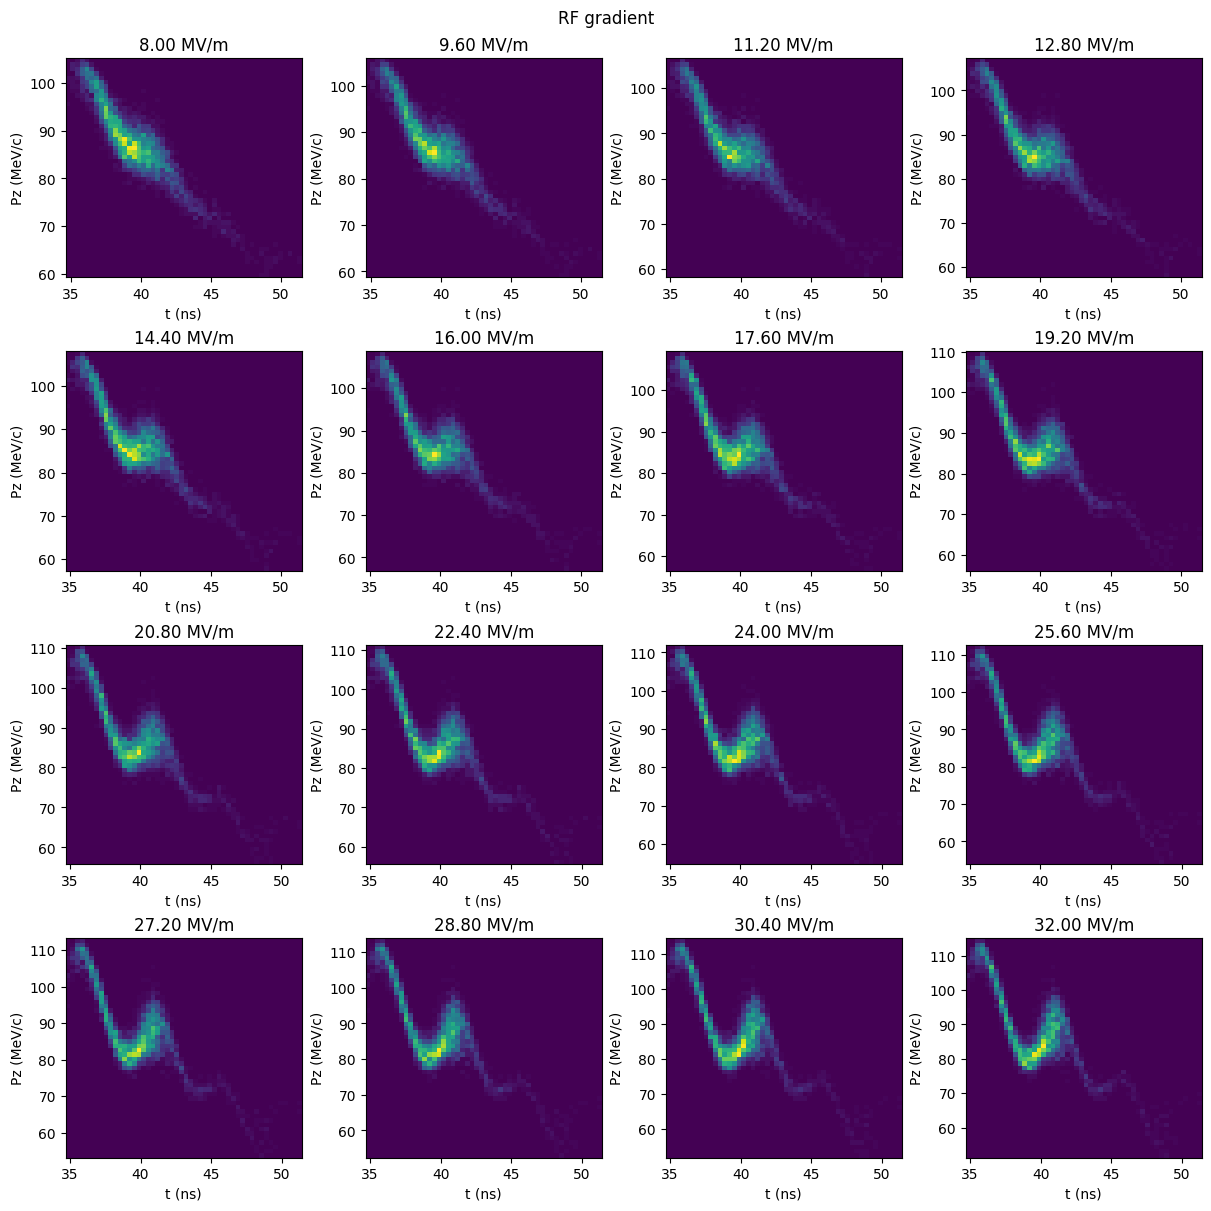

In [91]:
with open("results/scan_rf_grad.pkl", "rb") as file:
    results = pickle.load(file)

fig, axs = plt.subplots(nrows=4, ncols=4, layout="constrained")
fig.set_size_inches(12, 12)
fig.suptitle("RF gradient")
axs = axs.flatten()
for ax, (f, r) in zip(axs, results):
    ax.hist2d(r["t"], r["Pz"], bins=50)
    ax.set_xlabel("t (ns)")
    ax.set_ylabel("Pz (MeV/c)")
    ax.set_title(f"{f:.2f} MV/m")

Text(0.5, 0, 'RF intensity (MV/m)')

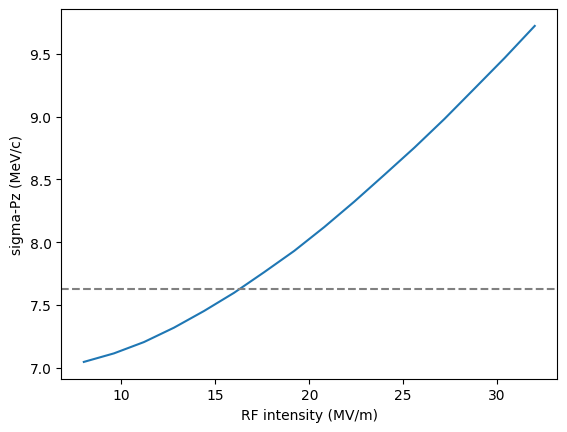

In [12]:
with open("results/scan_rf_grad.pkl", "rb") as file:
    results = pickle.load(file)

fig, ax = plt.subplots()
xlist, ylist = list(), list()
for x, res in results:
    xlist.append(x)
    ylist.append(np.std(res["Pz"]))
ax.plot(xlist, ylist)
ax.axhline(np.std(post_correct["Pz"]), linestyle="--", color="gray")
ax.set_ylabel("sigma-Pz (MeV/c)")
ax.set_xlabel("RF intensity (MV/m)")

In [81]:
phases = np.linspace(0, 90, 16)
post_drift = z_prop(post_correct, 5000)
def fun(phase):
    return run_g4beam(post_drift, "G4_RFCavity.g4bl", ficool=phase)
run_scan(fun, (phases,), "results/scan_rf_phase.pkl")
pass

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:39<00:00,  9.98s/it]


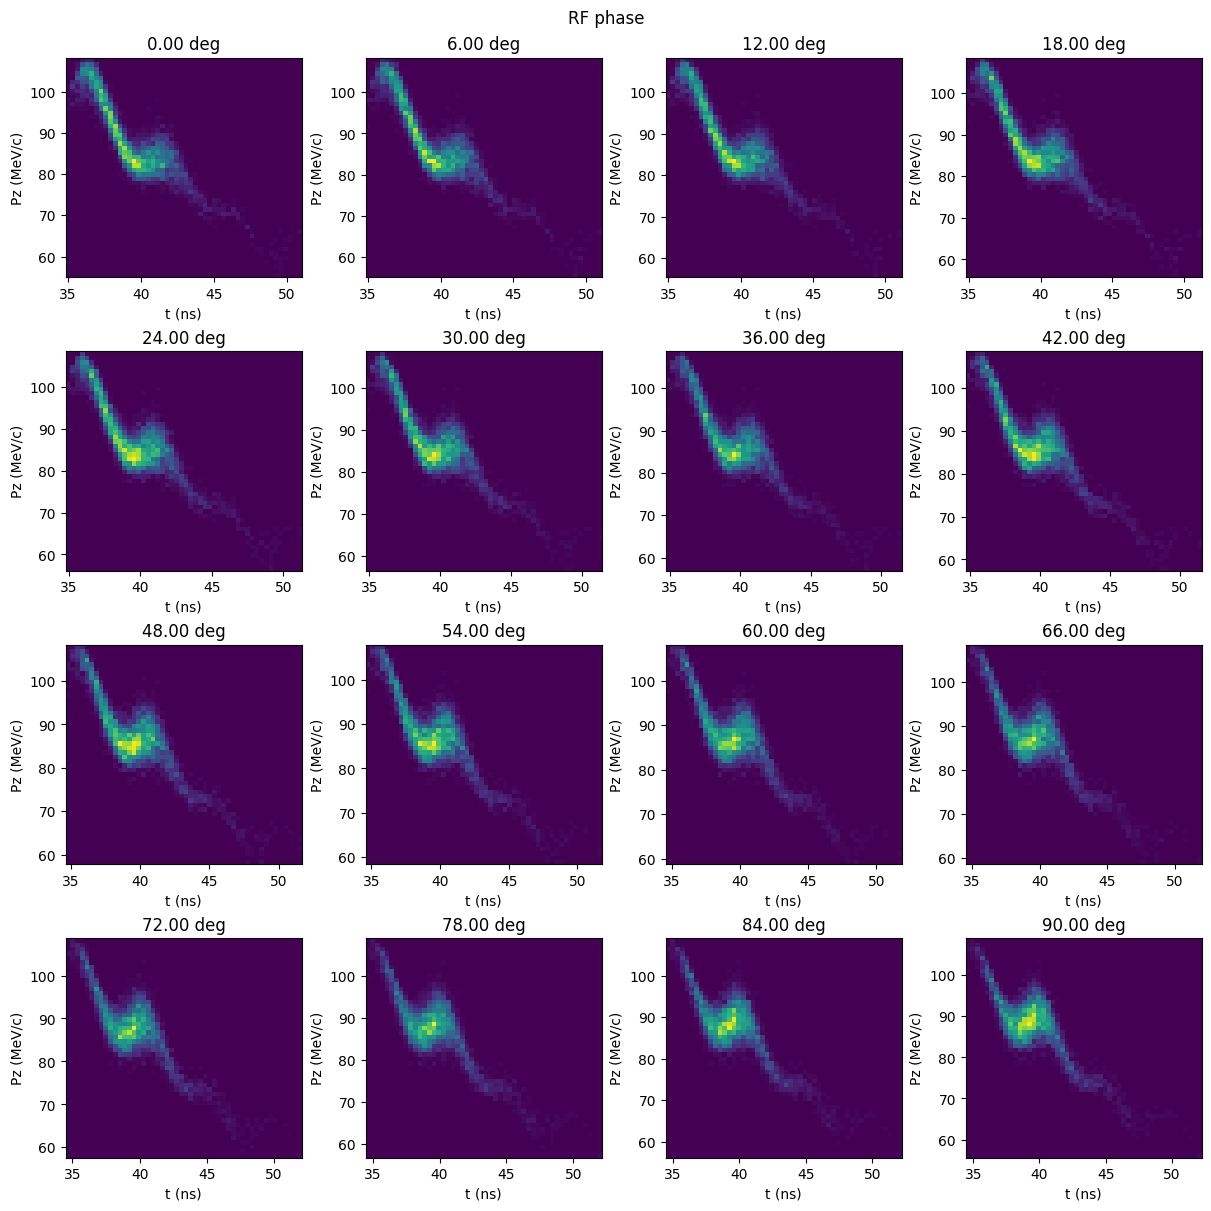

In [82]:
with open("results/scan_rf_phase.pkl", "rb") as file:
    results = pickle.load(file)

fig, axs = plt.subplots(nrows=4, ncols=4, layout="constrained")
fig.set_size_inches(12, 12)
fig.suptitle("RF phase")
axs = axs.flatten()
for ax, (f, r) in zip(axs, results):
    ax.hist2d(r["t"], r["Pz"], bins=50)
    ax.set_xlabel("t (ns)")
    ax.set_ylabel("Pz (MeV/c)")
    ax.set_title(f"{f:.2f} deg")

Text(0.5, 0, 'RF phase (degrees)')

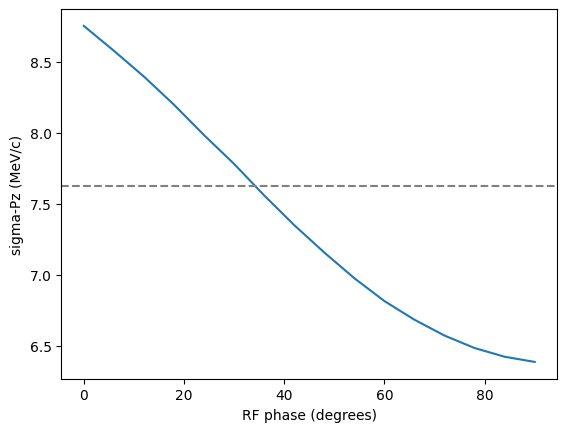

In [13]:
with open("results/scan_rf_phase.pkl", "rb") as file:
    results = pickle.load(file)

fig, ax = plt.subplots()
xlist, ylist = list(), list()
for x, res in results:
    xlist.append(x)
    ylist.append(np.std(res["Pz"]))
ax.plot(xlist, ylist)
ax.axhline(np.std(post_correct["Pz"]), linestyle="--", color="gray")
ax.set_ylabel("sigma-Pz (MeV/c)")
ax.set_xlabel("RF phase (degrees)")

# Gradient and frequency

## Scan 1

In [250]:
rf_length = 2500
drift_length = 8000
rf_freqs = np.linspace(0.03, 0.07, 15)
rf_grads = np.linspace(4,10,15)
rf_phase = 180

In [ ]:
drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(no_transverse, drift_to_start))

def fun(rf_grad, rf_freq):
    return recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))

results = run_scan(fun, (rf_grads, rf_freqs), "results/rf_grad_freq.pkl")

Text(0.5, 1.0, '15% cut')

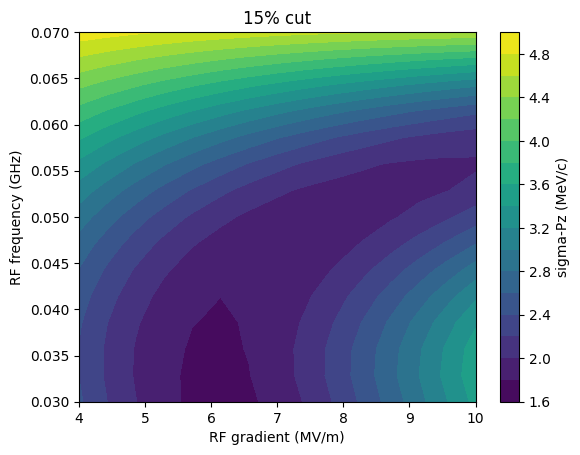

In [251]:
with open("results/rf_grad_freq.pkl", "rb") as file:
    results = pickle.load(file)
mesh = np.meshgrid(rf_grads, rf_freqs)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results))
meshx, meshy = mesh

fig, ax = plt.subplots()
cax = ax.contourf(meshx, meshy, meshz, levels=20)
ax.set_xlabel("RF gradient (MV/m)")
ax.set_ylabel("RF frequency (GHz)")
plt.colorbar(cax).set_label("sigma-Pz (MeV/c)")
ax.set_title("15% cut")

## Scan 2

In [252]:
rf_length = 2500
drift_length = 8000
rf_freqs = np.linspace(0.01, 0.04, 15)
rf_grads = np.linspace(4,10,15)
rf_phase = 180

In [ ]:
drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(no_transverse, drift_to_start))

def fun(rf_grad, rf_freq):
    return recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))

results = run_scan(fun, (rf_grads, rf_freqs), "results/rf_grad_freq_2.pkl")

Text(0.5, 1.0, '15% cut')

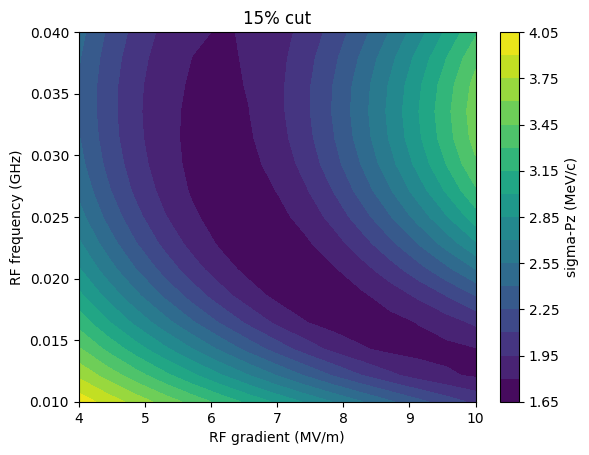

In [253]:
with open("results/rf_grad_freq_2.pkl", "rb") as file:
    results = pickle.load(file)
mesh = np.meshgrid(rf_grads, rf_freqs)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results))
meshx, meshy = mesh

fig, ax = plt.subplots()
cax = ax.contourf(meshx, meshy, meshz, levels=20)
ax.set_xlabel("RF gradient (MV/m)")
ax.set_ylabel("RF frequency (GHz)")
plt.colorbar(cax).set_label("sigma-Pz (MeV/c)")
ax.set_title("15% cut")

## With higher drift length

16 m will be used as the default from now on

In [7]:
rf_length = 2500
drift_length = 16000
rf_freqs = np.linspace(0.01, 0.06, 20)
rf_grads = np.linspace(1,8,20)
rf_phase = 180

In [233]:
drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(no_transverse, drift_to_start))

def fun(rf_grad, rf_freq):
    return recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))

results = run_scan(fun, (rf_grads, rf_freqs), "results/rf_grad_freq_16m.pkl")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [1:28:43<00:00, 13.31s/it]


Text(-30, 10, '5.63 MV/m, 0.0250 GHz')

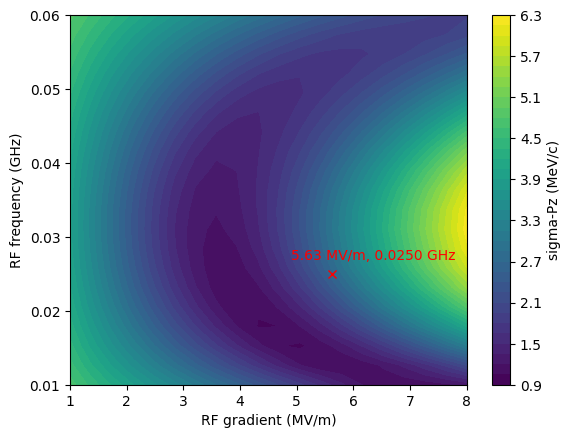

In [8]:
with open("results/rf_grad_freq_16m.pkl", "rb") as file:
    results = pickle.load(file)
mesh = np.meshgrid(rf_grads, rf_freqs)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results))
meshx, meshy = mesh

fig, ax = plt.subplots()
cax = ax.contourf(meshx, meshy, meshz, levels=50)
ax.set_xlabel("RF gradient (MV/m)")
ax.set_ylabel("RF frequency (GHz)")
plt.colorbar(cax).set_label("sigma-Pz (MeV/c)")
# ax.set_title("15% cut")

# minpoint = np.unravel_index(np.argmin(meshz), meshz.shape)
pointx, pointy = 5.630217759927936, 0.025
ax.plot(pointx, pointy, 'rx')
ax.annotate(f"{pointx:.2f} MV/m, {pointy:.4f} GHz", (pointx, pointy), c="red", xytext = (-30, 10), textcoords="offset points")

Text(0.5, 0.92, '15% cut')

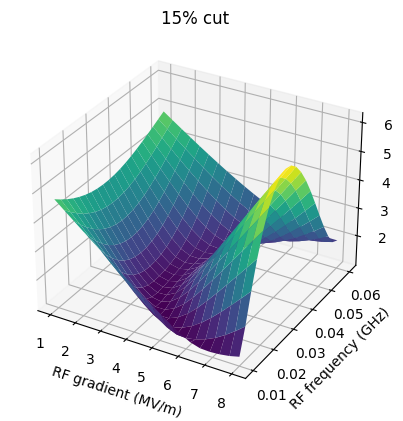

In [256]:
with open("results/rf_grad_freq_16m.pkl", "rb") as file:
    results = pickle.load(file)
mesh = np.meshgrid(rf_grads, rf_freqs)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results))
meshx, meshy = mesh

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
cax = ax.plot_surface(meshx, meshy, meshz, cmap="viridis")
ax.set_xlabel("RF gradient (MV/m)")
ax.set_ylabel("RF frequency (GHz)")
ax.set_title("15% cut")

# Phase angle

We expect this to be just 180 degrees

In [289]:
rf_length = 4765
drift_length = 16000
rf_freq = 0.025
rf_grad = 3.75
rf_phases = np.linspace(150, 210, 30)

drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(no_transverse, drift_to_start))

In [290]:
def fun(rf_phase):
    return recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))

run_scan(fun, (rf_phases,), filename="results/rf_phase_2.pkl")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [09:43<00:00, 19.44s/it]


[(150.0,
                x         y     z        Px        Py       Pz          t  \
  0     -0.796542 -0.715510  4815  0.001400  0.001257  81.0752   0.471381   
  1     -3.884680  1.075830  4815  0.006103 -0.001690  80.4000  -1.244019   
  2      1.933430  0.587571  4815 -0.001450 -0.000441  84.7089  -6.221819   
  3     -0.133351 -4.790900  4815  0.000083  0.002985  82.4459  -6.373019   
  4      0.976553  1.644400  4815 -0.001420 -0.002391  84.0087  -3.138219   
  ...         ...       ...   ...       ...       ...      ...        ...   
  11878 -0.581626  0.589857  4815  0.001123 -0.001139  83.8523   1.942281   
  11879 -0.631164 -0.098199  4815  0.000997  0.000155  85.7876   6.433281   
  11880  0.584799  0.449303  4815 -0.000667 -0.000513  80.5717  -3.922519   
  11881 -1.120320  4.380230  4815 -0.001717  0.006712  65.1112  21.192581   
  11882  2.052130 -1.653430  4815 -0.003184  0.002565  82.8566  -2.266119   
  
         PDGid  EventID  TrackID  ...  ProperTime  PathLength  P

Text(0.5, 1.0, 'RF length: 2.5 m')

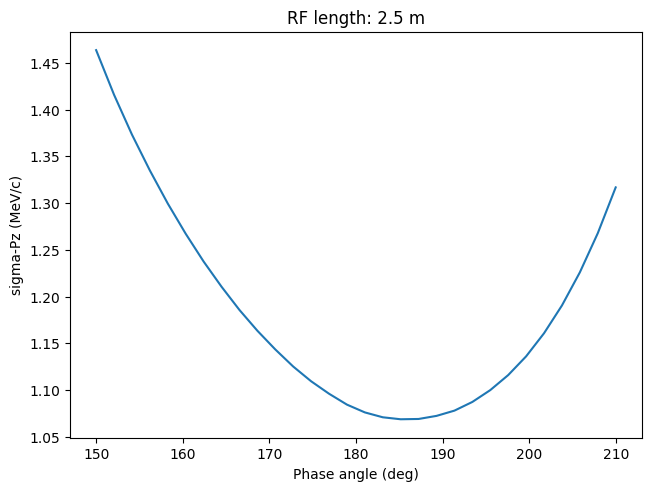

In [283]:
with open("results/rf_phase.pkl", "rb") as file:
    results = pickle.load(file)

fig, ax = plt.subplots(layout="constrained")
ax.errorbar(*qmap_to_arrays(rf_phases, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results)))
ax.set_xlabel("Phase angle (deg)")
ax.set_ylabel("sigma-Pz (MeV/c)")
ax.set_title("RF length: 2.5 m")

Text(0.5, 1.0, 'RF length: 4.7 m')

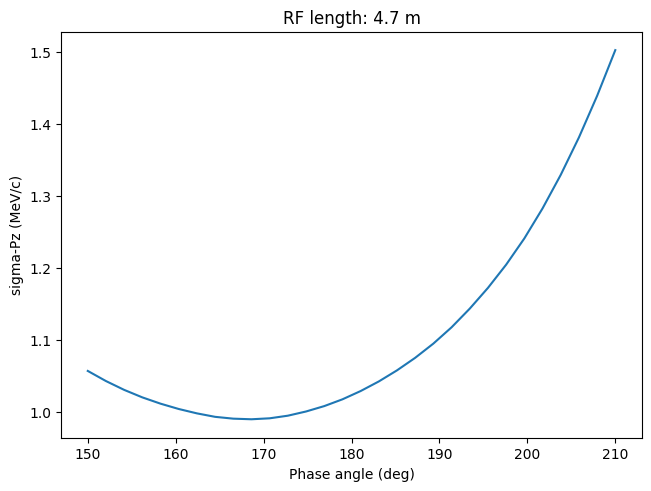

In [292]:
with open("results/rf_phase_2.pkl", "rb") as file:
    results = pickle.load(file)

fig, ax = plt.subplots(layout="constrained")
ax.errorbar(*qmap_to_arrays(rf_phases, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results)))
ax.set_xlabel("Phase angle (deg)")
ax.set_ylabel("sigma-Pz (MeV/c)")
ax.set_title("RF length: 4.7 m")

# Chamber length

In [312]:
rf_lengths = np.linspace(500, 10000, 50)
drift_length = 16000
rf_freq = 0.025
rf_grad = 3.75
rf_phase = 185

drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(no_transverse, drift_to_start))

In [278]:
def fun(rf_length):
    return recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))

run_scan(fun, (rf_lengths,), filename="results/rf_length.pkl")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [17:25<00:00, 20.92s/it]


[(500.0,
                x         y    z        Px        Py       Pz          t  PDGid  \
  0     -0.822866 -0.739156  550  0.000402  0.000361  85.1028  -0.175219     13   
  1     -3.935560  1.089930  550  0.001898 -0.000526  86.5378  -1.628569     13   
  2      1.874310  0.569605  550 -0.000721 -0.000219  95.3700  -4.894669     13   
  3     -0.128593 -4.619970  550  0.000047  0.001674  93.0340  -5.322419     13   
  4      0.976637  1.644540  550 -0.000457 -0.000769  92.2061  -2.512417     13   
  ...         ...       ...  ...       ...       ...      ...        ...    ...   
  11985 -0.612919  0.621592  550  0.000284 -0.000288  85.6946   1.535091     13   
  11986 -0.686294 -0.106776  550  0.000174  0.000027  81.3765   6.028551     13   
  11987  0.576049  0.442581  550 -0.000250 -0.000192  89.4503  -3.655476     13   
  11988 -1.088870  4.257270  550 -0.000529  0.002067  61.2284  19.930091     13   
  11989  2.067110 -1.665500  550 -0.000987  0.000795  90.1187  -2.005280     1

Text(0.5, 1.0, 'Phase: 185 deg')

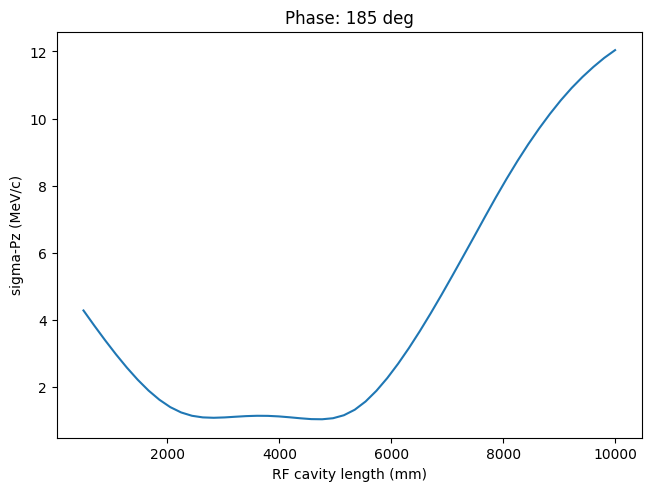

In [313]:
with open("results/rf_length.pkl", "rb") as file:
    results = pickle.load(file)

fig, ax = plt.subplots(layout="constrained")
ax.errorbar(*qmap_to_arrays(rf_lengths, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results)))
ax.set_xlabel("RF cavity length (mm)")
ax.set_ylabel("sigma-Pz (MeV/c)")
ax.set_title("Phase: 185 deg")

# Phase angle and chamber length

I've confirmed they are connected

In [13]:
drift_length = 16000
rf_freq = 0.025
rf_grad = 3.75

rf_lengths = np.linspace(2000, 6000, 15)
rf_phases = np.linspace(150, 210, 15)

In [14]:
def fun(rf_length, rf_phase):
    drift_to_start = drift_length-rf_length/2
    post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
    return recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))

results = run_scan(fun, (rf_lengths, rf_phases), "results/rf_length_phase_2.pkl")

100%|██████████████████████████████████████████████████████████████████████████████| 225/225 [1:05:31<00:00, 17.47s/it]


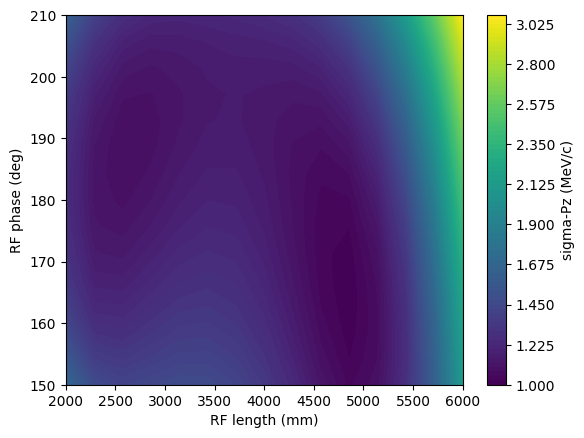

In [15]:
with open("results/rf_length_phase_2.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(rf_lengths, rf_phases)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results))
meshx, meshy = mesh

fig, ax = plt.subplots()
cax = ax.contourf(meshx, meshy, meshz, levels=100)
ax.set_xlabel("RF length (mm)")
ax.set_ylabel("RF phase (deg)")
plt.colorbar(cax).set_label("sigma-Pz (MeV/c)")

# Phase angle and RF gradient
I'm really hoping the optimal RF gradient is only dependent on drift length and frequency

In [26]:
drift_length = 16000
rf_freq = 0.025
rf_length = 4700

rf_phases = np.linspace(150, 210, 10)
rf_grads = np.linspace(1,8,10)

In [27]:
drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(no_transverse, drift_to_start))

def fun(rf_phase, rf_grad):
    return recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))

results = run_scan(fun, (rf_phases, rf_grads), "results/rf_phase_grad.pkl")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [32:10<00:00, 19.31s/it]


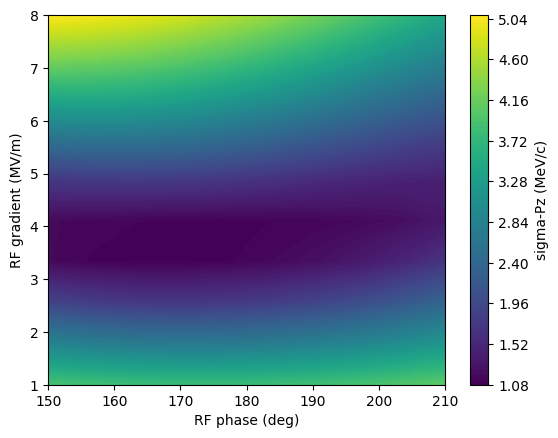

In [28]:
with open("results/rf_phase_grad.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(rf_phases, rf_grads)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results))
meshx, meshy = mesh

fig, ax = plt.subplots()
cax = ax.contourf(meshx, meshy, meshz, levels=100)
ax.set_xlabel("RF phase (deg)")
ax.set_ylabel("RF gradient (MV/m)")
plt.colorbar(cax).set_label("sigma-Pz (MeV/c)")

# Cavity length and RF gradient

In [33]:
drift_length = 16000
rf_phase = 165
rf_freq = 0.04

rf_lengths = np.linspace(2000, 6000, 10)
rf_grads = np.linspace(1,8,10)

In [34]:
def fun(rf_length, rf_grad):
    drift_to_start = drift_length-rf_length/2
    post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
    return recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))

results = run_scan(fun, (rf_lengths, rf_grads), "results/rf_length_grad_2.pkl")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:57<00:00, 17.37s/it]


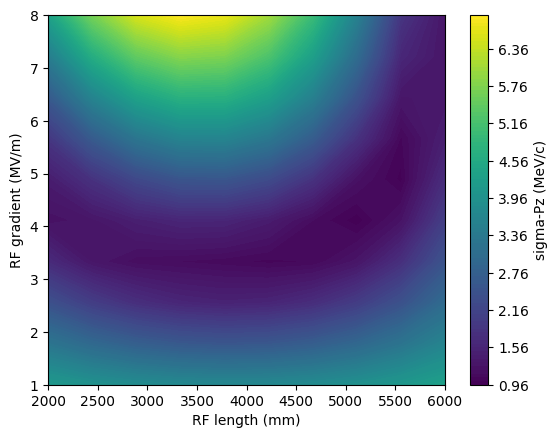

In [31]:
with open("results/rf_length_grad.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(rf_lengths, rf_grads)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results))
meshx, meshy = mesh

fig, ax = plt.subplots()
cax = ax.contourf(meshx, meshy, meshz, levels=100)
ax.set_xlabel("RF length (mm)")
ax.set_ylabel("RF gradient (MV/m)")
ax.set_title("25 MHz")
plt.colorbar(cax).set_label("sigma-Pz (MeV/c)")

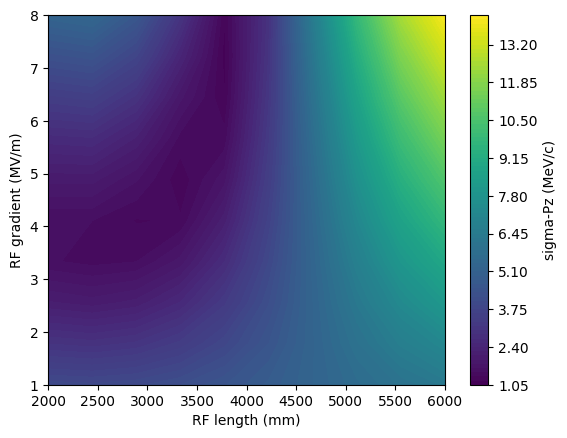

In [35]:
with open("results/rf_length_grad_2.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(rf_lengths, rf_grads)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: np.std(cut_pz(df)["Pz"]), results))
meshx, meshy = mesh

fig, ax = plt.subplots()
cax = ax.contourf(meshx, meshy, meshz, levels=100)
ax.set_xlabel("RF length (mm)")
ax.set_ylabel("RF gradient (MV/m)")
ax.set_title("40 MHz")
plt.colorbar(cax).set_label("sigma-Pz (MeV/c)")

# Optimization of phase, length, and gradient

Using scipy's implementation of the Nelder-Mead method

In [44]:
drift_length = 16000
rf_freq = 0.025

def fun(x):
    rf_phase, rf_length, rf_grad = x
    drift_to_start = drift_length-rf_length/2
    post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
    post_cavity = recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))
    return np.std(cut_pz(post_cavity)["Pz"])

optim_result = scipy.optimize.minimize(fun, [165, 4700, 3.75], method="Nelder-Mead", bounds=((140, 220), (2000, 6000), (1, 10)))
beep()

In [45]:
optim_result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.9100697698585662
             x: [ 1.421e+02  5.634e+03  5.393e+00]
           nit: 112
          nfev: 217
 final_simplex: (array([[ 1.421e+02,  5.634e+03,  5.393e+00],
                       [ 1.421e+02,  5.634e+03,  5.393e+00],
                       [ 1.421e+02,  5.634e+03,  5.393e+00],
                       [ 1.421e+02,  5.634e+03,  5.393e+00]]), array([ 9.101e-01,  9.101e-01,  9.101e-01,  9.101e-01]))

In [46]:
optim_result.x

array([1.42071681e+02, 5.63445391e+03, 5.39288950e+00])

# Second wedge

Assumes you have run **Individual run** to get `post_cavity`

In [19]:
# Prepare a distribution
before = recombine_transverse(post_cavity, reverse_transverse)
before = cut_pz(before)

print_all_params(before)

-----------------------------
Twiss parameters for X
emit  = 0.028741754691559443 mm
beta  = 0.038788820860519935 m
gamma = 239.11763034273906 1/m
alpha = 2.876645777282377
D     = 0.0017189770074475703 m
D'    = 0.1536703393562526

Twiss parameters for Y
emit  = 0.11919962793115424 mm
beta  = 0.024310277490532585 m
gamma = 58.830302455781144 1/m
alpha = 0.6558818320032964
D     = 0.00023185502737485555 m
D'    = 0.08344217062791723

Z-emittance:  4.8396140192355475 mm
Z std: 811.1549726208586 mm
pZ std: 1.0222010380203392 MeV/c
Mean momentum: 82.74922404782261 MeV/c
-----------------------------


In [22]:
length = 4.67
angle = 43.333
after = run_distribution(before, length, angle, 24, axis=1)
beep()

In [23]:
print_all_params(cut_outliers(after))

-----------------------------
Twiss parameters for X
emit  = 0.03160225918470407 mm
beta  = 0.051778233332093575 m
gamma = 267.2478515836449 1/m
alpha = -3.5829626870508546
D     = -2.7125556528657416e-05 m
D'    = 0.003319393618840857

Twiss parameters for Y
emit  = 0.038993049960307974 mm
beta  = 0.041569893950196175 m
gamma = 220.59263957240537 1/m
alpha = -2.858323395492319
D     = 0.0174895480122658 m
D'    = 0.08825915332314566

Z-emittance:  26.899419885195528 mm
Z std: 736.9540994079961 mm
pZ std: 6.855205966762395 MeV/c
Mean momentum: 71.9305391160561 MeV/c
-----------------------------


## Angle tuning

As the momentum has changed drastically, the angle must be retuned

**Individual run** should be run first to populate `post_cavity`

In [75]:
# Range to scan
angles = np.linspace(30, 70, 30)

# Constants
length = 7

In [77]:
def fun(angle):
    return run_distribution(before, length, angle, 24, axis=1)

results = run_scan(fun, (angles,), filename="results/second_wedge_angle.pkl")
beep()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:48<00:00,  5.62s/it]


Text(0, 0.5, 'Y-emittance (mm)')

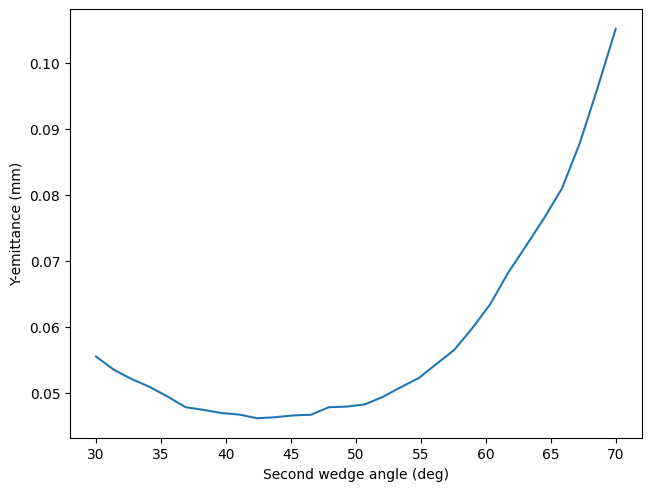

In [86]:
with open("results/second_wedge_angle.pkl", "rb") as file:
    results = pickle.load(file)

fig, ax = plt.subplots(layout="constrained")
ax.errorbar(*qmap_to_arrays(angles, calc_quantity(lambda df: emittances(df)[1], results)))
# ax.axhline(0.03, color="green", linestyle="--")
ax.set_xlabel("Second wedge angle (deg)")
ax.set_ylabel("Y-emittance (mm)")

Text(0, 0.5, 'X-emittance (mm)')

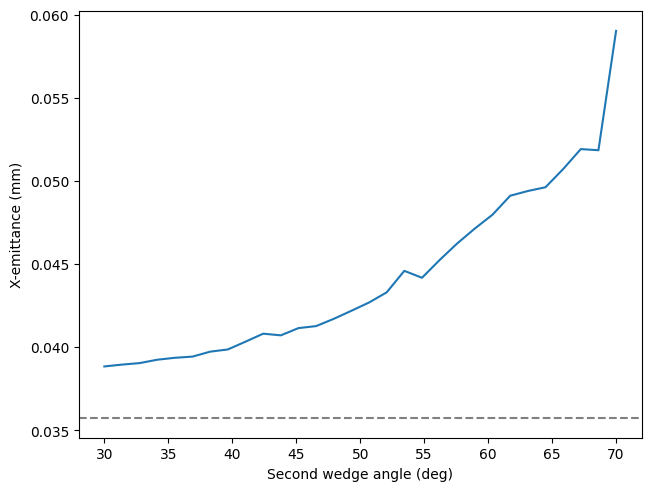

In [82]:
with open("results/second_wedge_angle.pkl", "rb") as file:
    results = pickle.load(file)

fig, ax = plt.subplots(layout="constrained")
ax.errorbar(*qmap_to_arrays(angles, calc_quantity(lambda df: emittances(df)[0], results)))
ax.axhline(emittances(before)[0], color="gray", linestyle="--")
ax.set_xlabel("Second wedge angle (deg)")
ax.set_ylabel("X-emittance (mm)")

## Angle and length tuning

In [58]:
# Range to scan
angles = np.linspace(30, 70, 10)
lengths = np.linspace(4, 10, 10)

In [59]:
def fun(length, angle):
    return run_distribution(before, length, angle, 24, axis=1)

results = run_scan(fun, (lengths, angles), filename="results/second_wedge_length_angle.pkl")
beep()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:21<00:00,  5.61s/it]


Text(-30, 10, '4.67 mm, 43.333 deg')

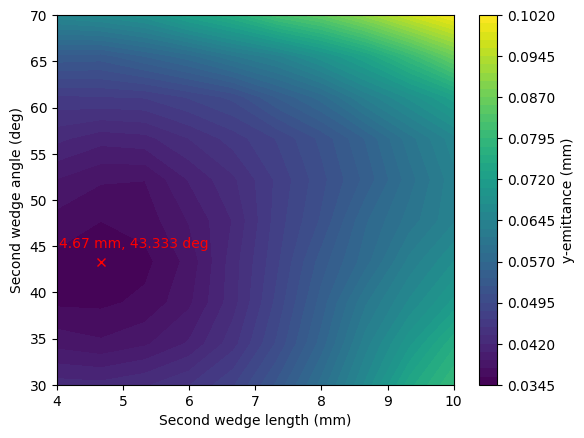

In [61]:
with open("results/second_wedge_length_angle.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[1], results))
meshx, meshy = mesh

fig, ax = plt.subplots()
cax = ax.contourf(meshx, meshy, meshz, levels=50)
ax.set_xlabel("Second wedge length (mm)")
ax.set_ylabel("Second wedge angle (deg)")
plt.colorbar(cax).set_label("y-emittance (mm)")

minpoint = np.unravel_index(np.argmin(meshz), meshz.shape)
ax.plot(meshx[minpoint], meshy[minpoint], 'rx')
ax.annotate(f"{meshx[minpoint]:.2f} mm, {meshy[minpoint]:.3f} deg", (meshx[minpoint], meshy[minpoint]), c="red", xytext = (-30, 10), textcoords="offset points")

## First wedge (for comparison)

In [4]:
# Values to use
t_emit = 0.110
momentum = 100
alpha = 0.7
beta = 0.030
pz_std = 0.8
l_emit = 1
vd_dist = 24

before = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit)

In [5]:
# Range to scan
angles = np.linspace(30, 70, 20)
lengths = np.linspace(4, 10, 20)

In [7]:
def fun(length, angle):
    return run_distribution(before, length, angle, vd_dist, axis=0)

results = run_scan(fun, (lengths, angles), filename="results/first_wedge_length_angle.pkl")
beep()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [44:15<00:00,  6.64s/it]


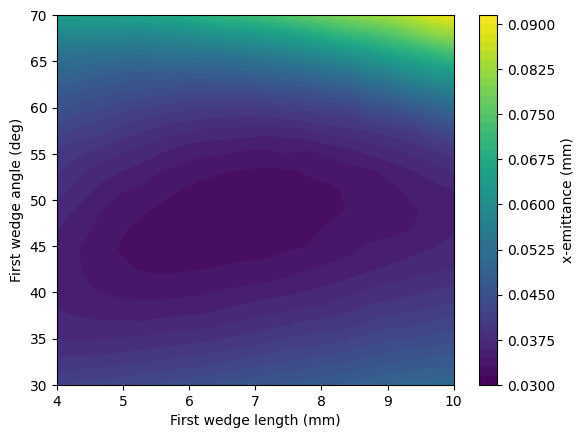

In [8]:
with open("results/first_wedge_length_angle.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[0], results))
meshx, meshy = mesh

fig, ax = plt.subplots()
cax = ax.contourf(meshx, meshy, meshz, levels=50)
ax.set_xlabel("First wedge length (mm)")
ax.set_ylabel("First wedge angle (deg)")
plt.colorbar(cax, ax=ax).set_label("x-emittance (mm)")

## Both graphs together

Text(-30, 10, '4.63 mm, 38.421 deg')

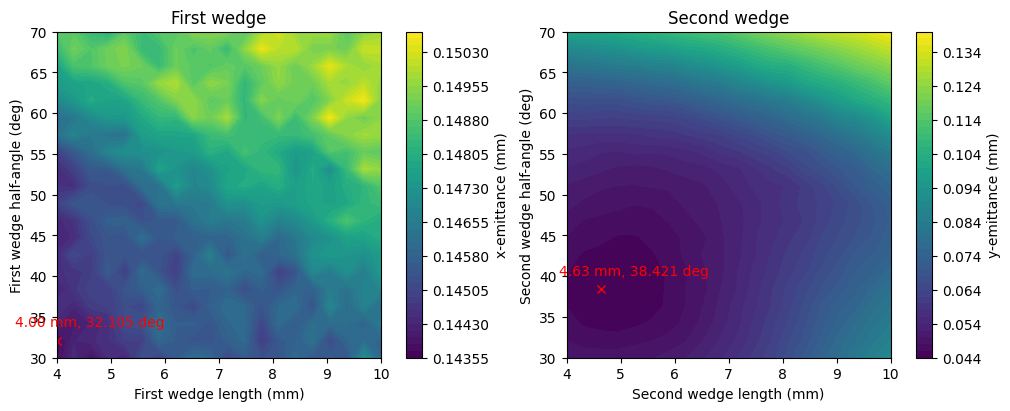

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, layout="constrained")
fig.set_size_inches(10, 4)

# First wedge

with open("results/first_wedge_length_angle.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[0], results))
meshx, meshy = mesh

cax = ax1.contourf(meshx, meshy, meshz, levels=50)
ax1.set_xlabel("First wedge length (mm)")
ax1.set_ylabel("First wedge half-angle (deg)")
ax1.set_title("First wedge")
plt.colorbar(cax, ax=ax1).set_label("x-emittance (mm)")

minpoint = np.unravel_index(np.argmin(meshz), meshz.shape)
ax1.plot(meshx[minpoint], meshy[minpoint], 'rx')
ax1.annotate(f"{meshx[minpoint]:.2f} mm, {meshy[minpoint]:.3f} deg", (meshx[minpoint], meshy[minpoint]), c="red", xytext = (-30, 10), textcoords="offset points")

# Second wedge

with open("results/second_wedge_length_angle.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[1], results))
meshx, meshy = mesh

cax = ax2.contourf(meshx, meshy, meshz, levels=50)
ax2.set_xlabel("Second wedge length (mm)")
ax2.set_ylabel("Second wedge half-angle (deg)")
ax2.set_title("Second wedge")
plt.colorbar(cax, ax=ax2).set_label("y-emittance (mm)")

minpoint = np.unravel_index(np.argmin(meshz), meshz.shape)
ax2.plot(meshx[minpoint], meshy[minpoint], 'rx')
ax2.annotate(f"{meshx[minpoint]:.2f} mm, {meshy[minpoint]:.3f} deg", (meshx[minpoint], meshy[minpoint]), c="red", xytext = (-30, 10), textcoords="offset points")

# Second wedge optimization

In [ ]:
def fun(x):
    rf_phase, rf_length, rf_grad = x
    drift_to_start = drift_length-rf_length/2
    post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
    post_cavity = recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad))
    return np.std(cut_pz(post_cavity)["Pz"])

optim_result = scipy.optimize.minimize(fun, [165, 4700, 3.75], method="Nelder-Mead", bounds=((140, 220), (2000, 6000), (1, 10)))
beep()

# First wedge single case

Duplicated from `wedge.ipynb`. Follow with **Dispersion correction and separate transverse**

In [9]:
t_emit = 0.110
momentum = 100
alpha = 0.7
beta = 0.030
pz_std = 0.8
l_emit = 1
vd_dist = 24
length = 6.478047916665673
angle = 48.15828562527895

before = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit)
post_wedge = run_distribution(before, length, angle, vd_dist, axis=0)
print_all_params(cut_outliers(post_wedge))

-----------------------------
Twiss parameters for X
emit  = 0.030938247330159624 mm
beta  = 0.0378378143446667 m
gamma = 216.14668850978506 1/m
alpha = -2.679275698961895
D     = 0.02030350126804501 m
D'    = -0.0599797735254508

Twiss parameters for Y
emit  = 0.11684520182153857 mm
beta  = 0.025410678259493537 m
gamma = 57.18057393960436 1/m
alpha = -0.6730506422792176
D     = -1.612110540764451e-05 m
D'    = 0.002787656720841891

Z-emittance:  6.993689906340039 mm
Z std: 179.01348982689314 mm
pZ std: 6.399682726834984 MeV/c
Mean momentum: 89.16297242506772 MeV/c
-----------------------------


# Reconstructed distribution into second wedge

In [4]:
print_all_params(post_cavity)

NameError: name 'post_cavity' is not defined